Before you turn this coursework in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

In [1]:
NAME = ""
CIS_USERNAME = ""

---

# COMP42415 Text Mining and Language Analytics
## Coursework 2023-24

### Instructions:

- <ins>**DO NOT RENAME THIS JUPYTER NOTEBOOK !!!**</ins>
- Please write the answers for each question in the respective cell. 
- You can add more cells if needed.
- If needed, you can upload additional files, e.g. pre-trained word embeddings, in the coursework's directory
- You can safely remove the `raise NotImplementedError()` line from each code cell.
- You can find information about markdown syntax from [here](https://www.markdownguide.org/basic-syntax/#emphasis).

## Implementation - Task 1
Prepare the dataset by applying any pre-processing or cleaning steps that you consider as necessary. Then, split the dataset into a training set containing 70% of the samples and a test set containing 30% of the samples. Follow an appropriate strategy for the split. You must use these training/test sets for all the models in this coursework. (**10%**)

In [1]:
import csv
import nltk
from nltk import sent_tokenize
from nltk import word_tokenize
from nltk.corpus import stopwords
from string import punctuation
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer  


import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score,precision_score,recall_score,classification_report
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dropout, Dense
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Embedding
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import LSTM, Bidirectional
from sklearn.decomposition import TruncatedSVD
import pickle


nltk.download('stopwords')
stopwords_english = stopwords.words('english')
#except the words that turn over the meanings of the text
stopwords_to_remove = ["can't",'no','nor','not','only','ain','aren','don', "don't", "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
stopwords_english = [word for word in stopwords_english if word not in stopwords_to_remove]

<ipython-input-1-a8340ebeab30>:11: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
[nltk_data] Downloading package stopwords to
[nltk_data]     /home3/qcgj68/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Score       0
Summary    27
Text        0
dtype: int64


<ipython-input-6-c9ed2f980130>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  food_reviews_uniq['Summary']=food_reviews_uniq['Summary'].astype(str)
<ipython-input-6-c9ed2f980130>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  food_reviews_uniq['Text']=food_reviews_uniq['Text'].astype(str)
<ipython-input-6-c9ed2f980130>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

No. of observations in each Score: Score
5    240802
4     53798
1     34923
3     28580
2     19919
Name: count, dtype: int64




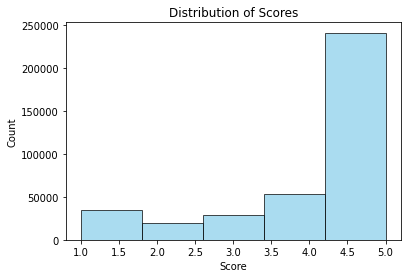

In [6]:
food_reviews = pd.read_csv('food_reviews.csv')
print(food_reviews.isna().sum())   #find the missing values
duplicates = food_reviews[food_reviews.duplicated()]
sorted_duplicates = duplicates.sort_values(by=['Score','Summary','Text'])     
food_reviews_uniq=food_reviews.drop_duplicates()   #delete the duplicates
food_reviews_uniq['Summary']=food_reviews_uniq['Summary'].astype(str)   #change the type of variables
food_reviews_uniq['Text']=food_reviews_uniq['Text'].astype(str)
food_reviews_uniq['Score'] = (food_reviews_uniq['Score']).astype('int') 

score_counts = food_reviews_uniq['Score'].value_counts()    #check the number of observations in each score
print("No. of observations in each Score:",score_counts)
print("\n")

scores = food_reviews_uniq['Score']   #visualization
plt.hist(scores, bins=5, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Scores')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

,Score,Summary,Text
1358,5,Yum Yum Yum,After enjoying Craisens for years on hikes and...
557,4,Naturally (and artificially) refreshing,In an ongoing effort to avoid diet soda during...
1479,3,It's supposed to be the Cappachino cooler but ...,I've been drinking these things since they cam...
530,3,"He loves them, but...","My dog LOVES these, but he throws up a few hou..."
518,3,Average vodka in a premium bottle,I bought this for a halloween party being prim...
...,...,...,...
14,3,ups,UPS left time sensitive marked package and ano...
656,4,Not for Me,"I broke a tooth on this item but, my dog loved..."
1304,3,If you ever wondered what it must be like to b...,... then these strips are for you. A friend o...
1620,3,A little bland but ...,... for those of us counting Weight Watcher p...




No.of samples in each Score: Score
5    1991
4    1991
3    1991
1    1991
2    1991
Name: count, dtype: int64




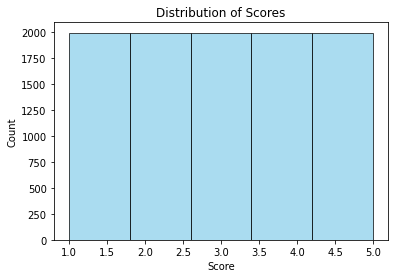

In [7]:
s1 = food_reviews_uniq[food_reviews_uniq["Score"] == 1]     #resampling. 
s2 = food_reviews_uniq[food_reviews_uniq["Score"] == 2]
s3 = food_reviews_uniq[food_reviews_uniq["Score"] == 3]
s4 = food_reviews_uniq[food_reviews_uniq["Score"] == 4]
s5 = food_reviews_uniq[food_reviews_uniq["Score"] == 5]

#randomly select the same number of observations in each score
s1_downsample = resample(s1, replace=True, n_samples=len(s2)//10, random_state=42).reset_index(drop=True)
s2_downsample = resample(s2, replace=True, n_samples=len(s2)//10, random_state=42).reset_index(drop=True)
s3_downsample = resample(s3, replace=True, n_samples=len(s2)//10, random_state=42).reset_index(drop=True)
s4_downsample = resample(s4, replace=True, n_samples=len(s2)//10, random_state=42).reset_index(drop=True)
s5_downsample = resample(s5, replace=True, n_samples=len(s2)//10, random_state=42).reset_index(drop=True)
frames = [s1_downsample,s2_downsample, s3_downsample,s4_downsample,s5_downsample]
result = pd.concat(frames)
result = result.sample(frac = 1)   #random it
display(result)
print("\n")

score_counts = result['Score'].value_counts()   #check the number of observations in each score of new sample set
print("No.of samples in each Score:",score_counts)
print("\n")

scores = result['Score']
plt.hist(scores, bins=5, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Scores')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()
# display(food_reviews_uniq)


In [8]:
result['Summary+Text']=result[['Summary','Text']].agg('. '.join,axis=1)  #combine summary and text together, split by '.'
# food_reviews_uniq.head()
result=result[['Score','Summary+Text']]
result

,Score,Summary+Text
1358,5,Yum Yum Yum. After enjoying Craisens for years...
557,4,Naturally (and artificially) refreshing. In an...
1479,3,It's supposed to be the Cappachino cooler but ...
530,3,"He loves them, but.... My dog LOVES these, but..."
518,3,Average vodka in a premium bottle. I bought th...
...,...,...
14,3,ups. UPS left time sensitive marked package an...
656,4,"Not for Me. I broke a tooth on this item but, ..."
1304,3,If you ever wondered what it must be like to b...
1620,3,A little bland but .... ... for those of us c...


In [9]:
def convert_to_lowercase(text): # Convert all characters to lowercase
    return text.lower()
def cleaning(text,stopwords):
    cl_text=[]
    t=str(convert_to_lowercase(text))
    t = re.sub(r'([.,:;?!-])\1+', r'\1', t)   
    t.replace(".",". ")
    t.replace("<a>","")  #remove the tags
    t.replace("<a />","")
    t.replace("<br>","")
    t.replace("<br />","")
    t=re.sub(r'href="https?://\S+"'+'|'+r'href="www\.\S+"',',',t)   #remove url links and webpages
    t=re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b',',',t)   #remove e-mail addresses
    cleaned_text= re.sub(r'[^\w\s\'.,:;?!-]', '', t)   #remove strange punctuations
    regex = "[^a-zA-Z\s]"   #select only texts
    new_text = re.sub(regex,"", cleaned_text)
    tokens = word_tokenize(new_text)   #word-tokenization
    accepted_tokens = []
    for token in tokens:
        if(token not in stopwords):   #remove stopwords
            accepted_tokens.append(token)
    result = " ".join(accepted_tokens)
    return result
result['cleaned_text'] = result['Summary+Text'].apply(cleaning,stopwords=stopwords_english)  #add a new col for cleaned text
result

,Score,Summary+Text,cleaned_text
1358,5,Yum Yum Yum. After enjoying Craisens for years...,yum yum yum enjoying craisens years hikes oatm...
557,4,Naturally (and artificially) refreshing. In an...,naturally artificially refreshing ongoing effo...
1479,3,It's supposed to be the Cappachino cooler but ...,supposed cappachino cooler changed something i...
530,3,"He loves them, but.... My dog LOVES these, but...",loves dog loves throws hours eating thought sy...
518,3,Average vodka in a premium bottle. I bought th...,average vodka premium bottle bought halloween ...
...,...,...,...
14,3,ups. UPS left time sensitive marked package an...,ups ups left time sensitive marked package ano...
656,4,"Not for Me. I broke a tooth on this item but, ...",not broke tooth item dog loved
1304,3,If you ever wondered what it must be like to b...,ever wondered must like cannibal strips friend...
1620,3,A little bland but .... ... for those of us c...,little bland us counting weight watcher points...


In [10]:
train, test = train_test_split(result, test_size = 0.30, random_state = 42)   #split the sample set 
X_train = train["cleaned_text"].values # Get the documents for training
Y_train = train["Score"].values # Get the labels for training
X_test = test["cleaned_text"].values # Get the documents for testing
Y_test = test["Score"].values # Get the labels for testing

no_of_training_samples = len(X_train)
no_of_test_samples = len(X_test)
total_samples = no_of_training_samples+no_of_test_samples
print("Total samples:\t\t%4d" % total_samples)
print("Training samples:\t%4d (%2.2f%s)" %
(no_of_training_samples,(no_of_training_samples/total_samples)*100,"%"))
print("Test samples:\t\t%4d (%2.2f%s)" %
(no_of_test_samples,(no_of_test_samples/total_samples)*100,"%"))


Total samples:		9955
Training samples:	6968 (69.99%)
Test samples:		2987 (30.01%)


## Implementation - Task 2
Implement a Naïve Bayes model for predicting the rating of a food review. Train your model on the training set and test it on the test set. Use an appropriate text representation. (**5%**)

Accuracy: 0.47840642785403414




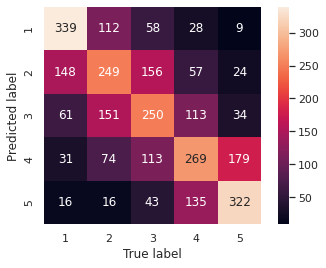

Accuracy:	0.478406
F1-score:	0.482742
Precision:	0.486660
Recall:		0.480068

Classification performance:
              precision    recall  f1-score   support

           1       0.62      0.57      0.59       595
           2       0.39      0.41      0.40       602
           3       0.41      0.40      0.41       620
           4       0.40      0.45      0.42       602
           5       0.61      0.57      0.59       568

    accuracy                           0.48      2987
   macro avg       0.49      0.48      0.48      2987
weighted avg       0.48      0.48      0.48      2987



In [8]:
bayes_model = make_pipeline(TfidfVectorizer(), MultinomialNB())
bayes_model.fit(X_train, Y_train) # Train the model on the training data
predicted_categories_bayes = bayes_model.predict(X_test) # Predict the categories of the test data
accuracy = bayes_model.score(X_test, Y_test)
print("Accuracy:", accuracy)
print("\n")

predicted_all_models={}   #create a list for the outcome of all models
predicted_all_models['bayes_model']=predicted_categories_bayes
all_models={}   #create a dictionary for the confusion matrix for all models

sns.set() # use seaborn plotting style
# Plot the confusion matrix
mat_bayes = confusion_matrix(Y_test, predicted_categories_bayes)
all_models['bayes_model']=mat_bayes
sns.heatmap(mat_bayes.T, square = True, annot=True, fmt = "d",
           xticklabels=['1','2','3','4','5'],
           yticklabels=['1','2','3','4','5'])
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.show()
# Compute and print classification performance metrics
print("Accuracy:\t%f" % accuracy_score(Y_test, predicted_categories_bayes))
print("F1-score:\t%f" % f1_score(Y_test, predicted_categories_bayes, average='macro'))
print("Precision:\t%f" % precision_score(Y_test, predicted_categories_bayes, average='macro'))
print("Recall:\t\t%f" % recall_score(Y_test, predicted_categories_bayes, average='macro'))
print("\nClassification performance:\n%s" % classification_report(Y_test, predicted_categories_bayes))

## Implementation - Task 3
Implement a k-Nearest Neighbours model for predicting the rating of a food review. Train your model on the training set and test it on the test set. Use an appropriate text representation. You must select the best k by examining the performance of the model for $k \in \{1,3,5,7\}$, using an appropriate cross-validation approach. Create a plot for k vs. classification performance to justify your choice. (**10%**)

Best k: 7


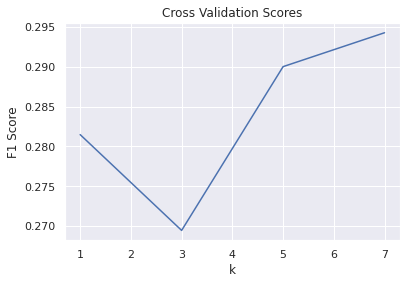

In [9]:
k_list = [1, 3, 5, 7]
cv_scores = []

for k in k_list:
    model = make_pipeline(TfidfVectorizer(), KNeighborsClassifier(n_neighbors=k))
    scores = cross_val_score(model, X_train, Y_train, cv=5, scoring='f1_macro')
    cv_scores.append(scores.mean())
best_k = k_list[np.argmax(cv_scores)]
print("Best k:", best_k)


plt.plot(k_list, cv_scores)
plt.xlabel('k')
plt.ylabel('F1 Score')
plt.title('Cross Validation Scores')
plt.show()


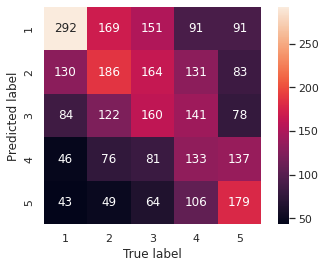



Accuracy:	0.318045
F1-score:	0.315058
Precision:	0.319271
Recall:		0.318772

Classification performance:
              precision    recall  f1-score   support

           1       0.37      0.49      0.42       595
           2       0.27      0.31      0.29       602
           3       0.27      0.26      0.27       620
           4       0.28      0.22      0.25       602
           5       0.41      0.32      0.35       568

    accuracy                           0.32      2987
   macro avg       0.32      0.32      0.32      2987
weighted avg       0.32      0.32      0.31      2987



In [10]:
knn_model = make_pipeline(TfidfVectorizer(), KNeighborsClassifier(n_neighbors=best_k))
knn_model.fit(X_train, Y_train)
predicted_test_k = knn_model.predict(X_test)

sns.set() # use seaborn plotting style
# Plot the confusion matrix
mat_knn = confusion_matrix(Y_test, predicted_test_k)
all_models['knn_model']=mat_knn
predicted_all_models['knn_model']=predicted_test_k
sns.heatmap(mat_knn.T, square = True, annot=True, fmt = "d",
            xticklabels=['1','2','3','4','5'],
            yticklabels=['1','2','3','4','5'])
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.show()
print("\n")
# Compute and print classification performance metrics
print("Accuracy:\t%f" % accuracy_score(Y_test, predicted_test_k))
print("F1-score:\t%f" % f1_score(Y_test, predicted_test_k, average='macro'))
print("Precision:\t%f" % precision_score(Y_test, predicted_test_k, average='macro'))
print("Recall:\t\t%f" % recall_score(Y_test, predicted_test_k, average='macro'))
print("\nClassification performance:\n%s" % classification_report(Y_test, predicted_test_k))

## Implementation - Task 4
Implement a Convolutional Neural Network (CNN) model for predicting the rating of a food review. The model must have at least two convolutional layers. Train your model on the training set and test it on the test set. Use an appropriate text representation. (**13%**)

In [11]:
MAX_VOCABULARY_WORDS = 5000 # The maximum number of words to be used (most frequent)
MAX_SEQUENCE_LENGTH = 200 # Number of words in each text. Sequence length to pad the outputs to.
EMBEDDING_DIM = 120 # Size of the word embedding to be used
# Create a preprocessing layer which maps text features to integer sequences
vectorize_layer = TextVectorization(
    max_tokens=MAX_VOCABULARY_WORDS, # Maximum size of the vocabulary for this layer
    output_mode='int', # Represent each word in the vocabulary with an integer
    output_sequence_length=MAX_SEQUENCE_LENGTH) # Pad the sequence length to size MAX_SEQUENCE_LENGTH
vectorize_layer.adapt(X_train) # Computes a vocabulary of string terms from tokens in a dataset.
vocabulary = vectorize_layer.get_vocabulary() # Get the vocabulary

# cnn
model_cnn = Sequential(name="MyCNN")
model_cnn.add(Input(shape=(1,), dtype=tf.string))
model_cnn.add(vectorize_layer)
model_cnn.add(Embedding(input_dim=MAX_VOCABULARY_WORDS, 
                    output_dim=EMBEDDING_DIM, 
                    input_length=MAX_SEQUENCE_LENGTH))
model_cnn.add(Conv1D(filters=96, kernel_size=5, activation='relu'))
model_cnn.add(Conv1D(filters=36, kernel_size=5, activation='relu'))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dropout(0.2))
model_cnn.add(Dense(6, activation='softmax'))

# summary
model_cnn.summary()
EPOCHS = 50
BATCH_SIZE = 5
LEARNING_RATE = 0.001

opt = Adam(learning_rate=LEARNING_RATE)

model_cnn.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
early = EarlyStopping(monitor="val_accuracy",patience=4,restore_best_weights=True,mode="auto")

history = model_cnn.fit(X_train, Y_train, 
                    epochs=EPOCHS, batch_size=BATCH_SIZE,
                    validation_split=0.1, 
                    callbacks=[early]
                   )


Model: "MyCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 200)               0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 200, 120)          600000    
                                                                 
 conv1d (Conv1D)             (None, 196, 96)           57696     
                                                                 
 conv1d_1 (Conv1D)           (None, 192, 36)           17316     
                                                                 
 global_max_pooling1d (Glob  (None, 36)                0         
 alMaxPooling1D)                                                 
                                                                 
 dropout (Dropout)           (None, 36)                0     

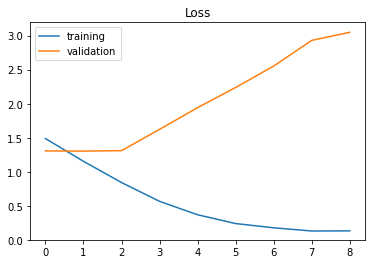

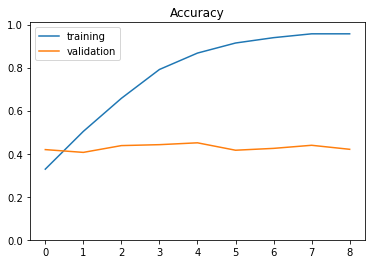

In [12]:
plt.title('Loss')
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.ylim(bottom=0.0)
plt.legend()
plt.show();

plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='training')
plt.plot(history.history['val_accuracy'], label='validation')
plt.ylim(bottom=0.0,top=1.01)
plt.legend()
plt.show()

94/94 [==============================] - 1s 15ms/step


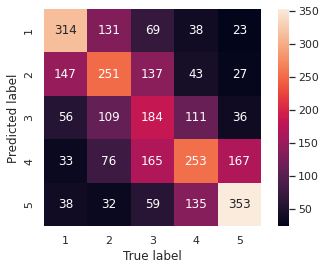



              precision    recall  f1-score   support

           1       0.55      0.53      0.54       588
           2       0.41      0.42      0.42       599
           3       0.37      0.30      0.33       614
           4       0.36      0.44      0.40       580
           5       0.57      0.58      0.58       606

    accuracy                           0.45      2987
   macro avg       0.45      0.45      0.45      2987
weighted avg       0.45      0.45      0.45      2987



In [14]:
# Use model to predict the class of the documents in the test set
pred_cnn = model_cnn.predict(X_test) 
predicted_labels_cnn = np.argmax(pred_cnn, axis=1)

sns.set() # use seaborn plotting style
# Plot the confusion matrix
mat_cnn = confusion_matrix(Y_test, predicted_labels_cnn)
all_models['model_cnn']=mat_cnn
predicted_all_models['model_cnn']=predicted_labels_cnn
sns.heatmap(mat_cnn.T, square = True, annot=True, fmt = "d",
            xticklabels=['1','2','3','4','5'],
            yticklabels=['1','2','3','4','5'])
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.show()
print("\n")

print(classification_report(Y_test,predicted_labels_cnn))

## Implementation - Task 5
Implement a Recurrent Neural Network (RNN) or a Long Short-Term Memory (LSTM) model for predicting the rating of a food review. The model must have at least two RNN/LSTM layers. Train your model on the training set and test it on the test set. Use an appropriate text representation. (**12%**)

In [50]:
MAX_VOCABULARY_WORDS = 4000
MAX_SEQUENCE_LENGTH = 100

# Tokenize and pad sequences
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(X_train)

tokenizer.num_words = MAX_VOCABULARY_WORDS
#padding training set and testing set
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_padded = tf.keras.preprocessing.sequence.pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH)

X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_padded = tf.keras.preprocessing.sequence.pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH)

# Create embedding matrix
vocabulary_size = min(MAX_VOCABULARY_WORDS, len(tokenizer.word_index) + 1)
embedding_dim = 100


In [15]:
glove_path = 'glove.6B.100d.txt'  #download pretrained word embeddings
embeddings_index = {}
with open(glove_path, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

embedding_matrix = np.zeros((vocabulary_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i >= MAX_VOCABULARY_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [41]:
svd = TruncatedSVD(n_components=90, random_state=42)  #dimension reduction
embedding_matrix_reduced = svd.fit_transform(embedding_matrix)


model = Sequential(name="MyLSTM")
model.add(Embedding(input_dim=vocabulary_size, output_dim=90, 
                    weights=[embedding_matrix_reduced], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
model.add(LSTM(96, return_sequences=True))
model.add(Bidirectional(LSTM(48, go_backwards=True, dropout=0.2)))
model.add(Dense(5, activation='softmax'))


opt = Adam(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
# Define early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True, mode='auto')
history = model.fit(X_train_padded, Y_train-1, epochs=50, batch_size=5, 
                    validation_split=0.1, callbacks=[early_stopping])
# Evaluate model
test_loss, test_accuracy = model.evaluate(X_test_padded, Y_test-1)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Epoch 1/50
1255/1255 [==============================] - 100s 76ms/step - loss: 1.4136 - accuracy: 0.3709 - val_loss: 1.3535 - val_accuracy: 0.4017
Epoch 2/50
1255/1255 [==============================] - 94s 75ms/step - loss: 1.2564 - accuracy: 0.4516 - val_loss: 1.2955 - val_accuracy: 0.4448
Epoch 3/50
1255/1255 [==============================] - 94s 75ms/step - loss: 1.1661 - accuracy: 0.4988 - val_loss: 1.2306 - val_accuracy: 0.4864
Epoch 4/50
1255/1255 [==============================] - 94s 75ms/step - loss: 1.0784 - accuracy: 0.5382 - val_loss: 1.2224 - val_accuracy: 0.4907
Epoch 5/50
1255/1255 [==============================] - 94s 75ms/step - loss: 0.9807 - accuracy: 0.5894 - val_loss: 1.2433 - val_accuracy: 0.5050
Epoch 6/50
1255/1255 [==============================] - 94s 75ms/step - loss: 0.8622 - accuracy: 0.6402 - val_loss: 1.3134 - val_accuracy: 0.4792
Epoch 7/50
1255/1255 [==============================] - 94s 75ms/step - loss: 0.7276 - accuracy: 0.7107 - val_loss: 1.4022 

94/94 [==============================] - 3s 32ms/step


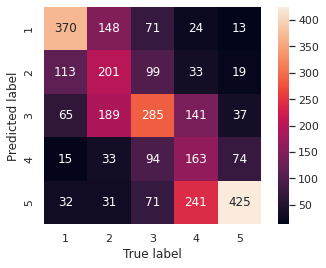



              precision    recall  f1-score   support

           1       0.59      0.62      0.61       595
           2       0.43      0.33      0.38       602
           3       0.40      0.46      0.43       620
           4       0.43      0.27      0.33       602
           5       0.53      0.75      0.62       568

    accuracy                           0.48      2987
   macro avg       0.48      0.49      0.47      2987
weighted avg       0.48      0.48      0.47      2987



In [51]:
sns.set() # use seaborn plotting style
# Plot the confusion matrix
pred_lstm = model.predict(X_test_padded) 
predicted_labels_lstm = np.argmax(pred_lstm, axis=1)

mat_lstm = confusion_matrix(Y_test, predicted_labels_lstm+1)
all_models['model_lstm']=mat_lstm
predicted_all_models['model_lstm']=predicted_labels_lstm
sns.heatmap(mat_lstm.T, square = True, annot=True, fmt = "d",xticklabels=['1','2','3','4','5'],
            yticklabels=['1','2','3','4','5'])
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.show()
print("\n")

print(classification_report(Y_test,predicted_labels_lstm+1))

In [29]:
model.summary()

Model: "MyLSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 90)           360000    
                                                                 
 lstm (LSTM)                 (None, 100, 96)           71808     
                                                                 
 bidirectional (Bidirection  (None, 96)                55680     
 al)                                                             
                                                                 
 dense_1 (Dense)             (None, 6)                 582       
                                                                 
Total params: 488070 (1.86 MB)
Trainable params: 128070 (500.27 KB)
Non-trainable params: 360000 (1.37 MB)
_________________________________________________________________


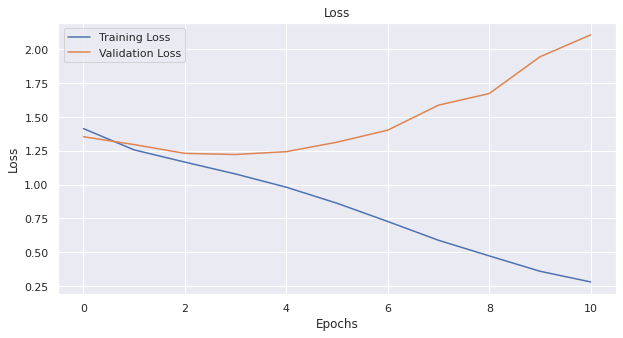

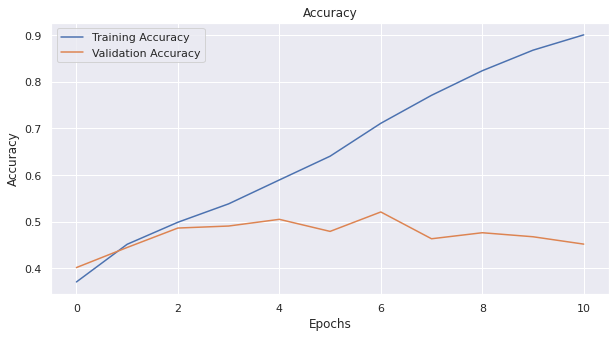

In [52]:
#visualization
plt.figure(figsize=(10, 5))
plt.title('Loss')
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.autoscale()
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 5))
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.autoscale()
plt.grid(True)
plt.show()
pkl_filename = "lstm_model.pkl"
with open(pkl_filename, 'wb') as file: # Open file as binary file for writing (wb)
    pickle.dump(model, file)

## Implementation - Task 6
Compute the confusion matrix, accuracy, F1-score, precision and recall for each model. (10%)

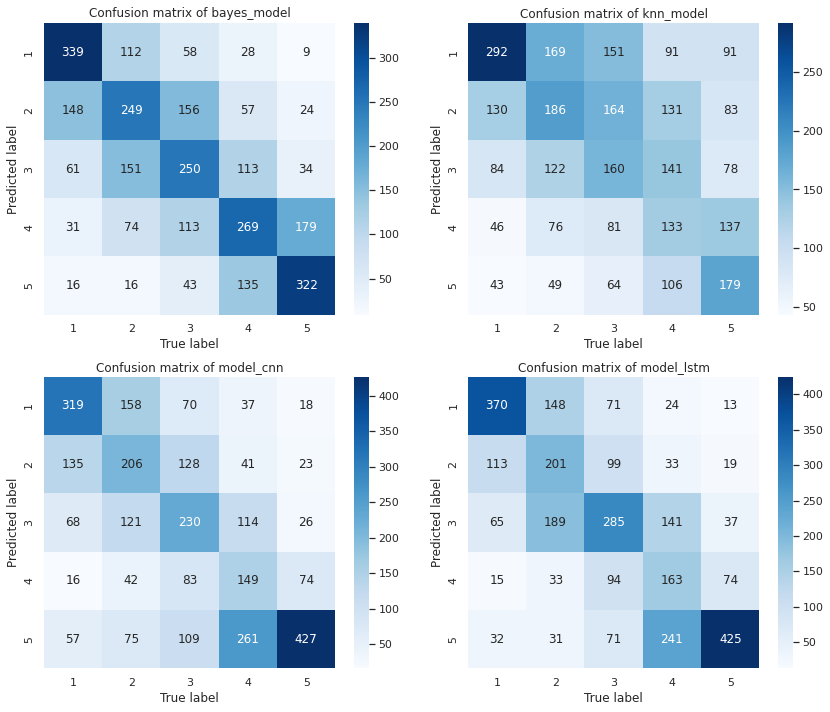

<ipython-input-53-e5bfd1f3ebfe>:34: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  evaluation_df = pd.concat([evaluation_df, pd.DataFrame([new_row])], ignore_index=True)
/apps/jupyterhub/COMP42415/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/apps/jupyterhub/COMP42415/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavi

,Model,Accuracy,F1-score,Precision,Recall
0,bayes_model,0.478406,0.482742,0.486660,0.480068
1,knn_model,0.318045,0.315058,0.319271,0.318772
2,model_cnn,0.445598,0.433024,0.439363,0.449713
3,model_lstm,0.213257,0.171962,0.175980,0.175969


In [53]:
def scores(model_names):
    sns.set()
    num_models = len(model_names)
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    for i, model_name in enumerate(model_names):
        row=i//2
        col=i%2
        sns.heatmap(all_models[model_name].T, square=True, annot=True, fmt="d",
                    xticklabels=['1', '2', '3', '4', '5'], 
                    yticklabels=['1', '2', '3', '4', '5'], 
                    ax=axes[row, col],
                    cmap="Blues")
        axes[row, col].set_title("Confusion matrix of {}".format(model_name))
        axes[row, col].set_xlabel("True label")
        axes[row, col].set_ylabel("Predicted label")
    plt.tight_layout() 
    plt.show()

model_names = list(all_models.keys())
scores(model_names)


evaluation_df = pd.DataFrame(columns=['Model', 'Accuracy', 'F1-score', 'Precision', 'Recall'])
for model_name in model_names:
    accuracy = accuracy_score(Y_test, predicted_all_models[model_name])
    f1 = f1_score(Y_test, predicted_all_models[model_name], average='macro')
    precision = precision_score(Y_test, predicted_all_models[model_name], average='macro')
    recall = recall_score(Y_test, predicted_all_models[model_name], average='macro')
    new_row = {'Model': model_name, 
               'Accuracy': accuracy, 
               'F1-score': f1, 
               'Precision': precision, 
               'Recall': recall}
    evaluation_df = pd.concat([evaluation_df, pd.DataFrame([new_row])], ignore_index=True)
display(evaluation_df)


## Implementation - Task 7
Store the **four** trained models in files and implement a function `predict_food_review(text, model)` that given a <ins>text string</ins> (“`text`”) and model <ins>filename</ins> (“`model`”), it will load the pre-trained model, and predict the food review rating of the input text. The function should be able to work without requiring to rerun all or part of your code. (**10%**)

In [59]:
def predict_food_review(text, model_name):
    model_path = f"{model_name}.pkl"
    with open(model_path, 'rb') as file:
        model = pickle.load(file)
    text = cleaning(text, stopwords_english)
    text_list=[]
    text_list.append(text)
    if model_name=='lstm_model':
        text_seq = tokenizer.texts_to_sequences(text_list)
        text_padded = tf.keras.preprocessing.sequence.pad_sequences(text_seq, maxlen=100)
        predicted_rating = model.predict(text_padded)
        predicted_ratings = np.argmax(predicted_rating, axis=1)
        predicted_ratings +=1
        print("The predicted rating of the comment is:", predicted_ratings[0])
    elif model_name =='knn_model':
        predicted_rating = model.predict(text_list)
        print("The predicted rating of the comment is:", predicted_rating[0])
    elif model_name=='cnn_model' or 'naive_bayes_model':
        predicted_rating = model.predict(text_list)
        predicted_ratings = np.argmax(predicted_rating, axis=1)
        print("The predicted rating of the comment is:", predicted_ratings[0])
    else:
        print("There are no such model! Please choose other models!")
        

for _ in range(4):  
    comments = str(input("Please enter your comments about the food: "))
    model_name = str(input("Please enter the name of the model: "))
    predict_food_review(comments, model_name)






Please enter your comments about the food: I'm really disappointed with the food here; it's so bland, I can't taste anything!
Please enter the name of the model: naive_bayes_model
1/1 [==============================] - 0s 107ms/step
The predicted rating of the comment is: 1
Please enter your comments about the food: I'm loving the food at this restaurant; it's a culinary delight!"
Please enter the name of the model: lstm_model
1/1 [==============================] - 1s 929ms/step
The predicted rating of the comment is: 5
Please enter your comments about the food: This dish is just ok, the flavors are good! The meat maybe not that fresh enough though
Please enter the name of the model: knn_model
The predicted rating of the comment is: 4
Please enter your comments about the food: The service at this place is terrible, and the food is mediocre; I won't be coming back again!
Please enter the name of the model: cnn_model
1/1 [==============================] - 0s 107ms/step
The predicted rati

## Report - Task 1
Critical discussion about the dataset (suitability, problems, class balance, etc.). (**6%**)

Three variables make up the dataset regarding food reviews on Amazon: the text of the comments, their scores (from 1 to 5) and a brief summary of each comment. This data collection contains more than 500000 comments, with over 150000 of them being duplicates. In addition, the "Summary" has roughly 27 missing values.  Additionally, there is an imbalance in the number of observations in each score. While the numbers of score 2 only make up less than 5% of the dataset, the total numbers of score 5 provided by online users make up over 50% of the dataset. In the meantime, the proportion of the other scores' numbers is identical.

## Report - Task 2
Description and justification of the data preparation step(s) used. (**6%**)

Initially, I downsampled the dataset, took the equal amount of observations from each score, and mixed them together to create a subset of the original dataset in order to balance the sample set. There are 1991 observations in each score, for a total of 9955 observations in the subset. I then created a new column by combining the "Summary" and "Text" and separating them with a period. I used this new column together with the column labeled "Score" as my new sample set. I left the missing data in place. In general, the sample set as a whole show that the percentage of missing values is negligible. However, the missing information only occurs in the "Summary," so this problem can be resolved by combining the text and summary.  As the initial stage of data cleaning, I then changed every word to lowercase. Next, I removed every tag in the context—such as <br> and <br />—as well as all email addresses and web links because they brought nothing to the emotional expressions in the text. Finally, I extracted purely the text and dropped the numbers because they also didn't convey any emotional information. It is difficult for us to determine what number indicates greater liking, even though in some cases, the higher the number, the more individuals like the dish. Due to this, I don't take the numbers in the texts into consideration in this situation. After that, I tokenized the text in words and eliminated stopwords, which omitted antisense words and completely changed the text's meaning. In addition, I added a new column to the sample set based on the outcome. 
At last, I split the sample set into a 7:3 ratio across the training and test sets. 


## Report - Task 3
Description and commentary on the machine learning architectures used, including a description and justification of the text representation method(s) used. (**7%**)

1、	Naïve Bayes model.
The foundation of the naïve Bayes model is the idea that all terms and characteristics are conditionally independent, as well as the idea of Bayes theory. I represented text using the TF-IDF approach as a result.  The text's frequency of each word can be calculated using TF-IDF, which also gauges how unique each word is from the others. Each word in the text is represented by a matrix that is returned. In my pipeline, I first transform the input into TF-IDF vectors before using a Multinomial Naïve Bayes algorithm for multiple classification. In order to predict the food ratings on the test set, I first trained the model on the training set. 

2、	k-Nearest Neighbors model.
Samples are categorized by this model based on how closely their attributes match those in the training set. It determines the input class based on the majority class among its closest neighbors and computes the distance between the training samples and samples. I put up a pipeline and represented text using the TF-IDF approach, which has the same structure as the Naïve Bayes model. In addition, I experimented with 1, 3, 5, and 7 as the model's k values. I computed each F1 score and used 5-fold cross-validation to choose the optimum k. The best k value is correlated with the highest F1 score. Following the selection of the best k, I predicted the food ratings using the model on the test set. 

3、Convolutional Neural Network.
CNN is primarily utilized for network structure data, particularly text and image data. The basic idea is to automatically extract features from convolutional layers, pooling layers, and fully connected layers without the need for feature design. 
First, text was tokenized into words using the "TextVecotization" layer, and then the text was converted into integer sequences. The sequences were then padded to a predetermined length. Subsequently, an embedding layer was incorporated to map the fixed-size dense vectors and integer word sequences. To capture the text features, I then added two 1D convolutional layers with ReLU activation. In addition, I employed a dropout layer to avoid overfitting and a global max-pooling layer to down sample the feature maps to speed up the running process. Early halting was used to avoid overfitting while the sparse categorical cross-entropy loss function and Adam optimizer were being assembled in the model. 

4、Long Short-Term Memory model.
The model, which belongs to the family of recurrent neural networks (RNNs), is frequently applied to emotional analysis and text classification. It is capable of efficiently capturing the important details in lengthy sequences. 
In order to provide each text segment the same length, I first converted the text into numerical sequences and filled the text sequence. Next, I converted each word into a vector by using the pretrained word-embedding technique "GloVe" for the word embedding. Subsequently, I lowered the word embedding matrix's dimension in order to boost efficiency and lower computing complexity. 
To extract better sequence properties, I utilized a one-way and a bidirectional LSTM layer inside the model. For multiclassification jobs, I added an output layer. Early halting was used to avoid overfitting while the sparse categorical cross-entropy loss function and Adam optimizer were being assembled in the model.


## Report - Task 4
Detailed performance evaluation of the trained machine learning models in terms of the computed performance metrics. (**5%**)

We can observe from the plots that all models predict ratings of comments with true scores of 1 and 5 more accurately than comments with genuine ratings of 2, 3, and 4. With the highest accuracy of 49.14%, the highest F1-score of 47.64%, and the highest recall value of 49.18% among these models, LSTM outperformed the others; the precision value of 47.82% ranked second, only behind the Naïve Bayes Model. Meanwhile, it did not perform well for any of the lowest indexes, even if the k Nearest Neighbors Model's best k value, 7, had been chosen. We can also see from the confusion matrix that sentences with actual scores between 1 and 5 are the ones that the LSTM Model predicts the most accurately. Out of the four models, the Naïve Bayes model was the most accurate in predicting texts with an actual score of 3, and it was also the most accurate at predicting the number of texts with five scores.

## Report - Task 5
Critical discussion on the achieved results, including potential limitations and usage instructions/suggestions. (**6%**)

The results of all four models show that, in texts with actual scores between 1 and 5, all four models perform well in terms of prediction since it is simple to extract the characteristics of "the best" and "the worst" from the original texts. However, it can be challenging to evaluate these models' embodied attitudes if the text has a neutral emotional presentation. Consequently, these models can be further refined to extract more specific data in order to assess the emotions expressed in those neutral texts. Furthermore, I discovered that the Naïve Bayes model ran the fastest throughout training and testing, while the k-Nearest Neighbors model tested quite slowly after training quickly. LSTM Model had the slowest speed during both the training and testing phases, despite my reduction of the input matrix's dimensions. Therefore, if it is used, it can also be tuned for speed due to its high accuracy rate. 
Furthermore, because the data set is too big, it is difficult to determine whether there are any other noise patterns in the dataset. As a result, there are certain restrictions on the project's cleaning procedure for unforeseen forms. 
Another problem is the excessive imbalance in the original data set, which may affect feature extraction in the process. A very high percentage of observations were scored 5, and there are very few observations in the other categories. I also drew based on the group with the fewest observations because even I decided to extract the same number of observations for each score. 
Tips: 
While the feedback result of CNN and LSTM models is the probability value of the text falling on each group, the maximum probability needs to be selected, and the output indexes need to be added to the maximum value selection, the prediction result of Naïve Bayes and K-Nearest Neighbors models can be output directly. Nevertheless, the final part is now part of the definition function, so you can input the text and output the expected outcome right away. 
Moreover, these models are limited to English usage. So, they can only predict the comments in English version.
